# Appendix Causal graphs
### Agenda

- Basic elements of causal graphs
- Causal graphs and structural equation
- Causal graphs and the potential outcome model
- Causal graphから実際の推定への落とし込み


### Package Install

In [1]:
#!pip install causalgraphicalmodels

### Import

In [2]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import matplotlib
import numpy as np
from causalgraphicalmodels import CausalGraphicalModel

## 1. Causal graphs

Causal graphsはPOMと比較して計量経済学ではメジャーではないが、以下のメリットがある

1. causal systemの明確化（仮説レベル）
2. identification strategiesの明確化

### Basic elements of causal graphs

- nodes(観測可能なものは●、不可能なものは○)
- edges
- directed paths
 - parent and child

<img src = "https://github.com/RyoNakagami/omorikaizuka/blob/master/Econometrics/causal_graphs_2.jpg?raw=true">

### Mediation, Mutual dependence and Mutual causation

<img src = "https://github.com/RyoNakagami/omorikaizuka/blob/master/Econometrics/causal_graph_3.jpg?raw=true">




Mutual causationはCollisionとも呼ばれる

### Collisionとdependence

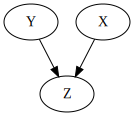

In [3]:
collision = CausalGraphicalModel(
    nodes=["X", "Y", "Z"],
    edges=[
        ("X", "Z"), 
        ("Y", "Z"),
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
collision.draw()

- X: 車のバッテリー状態
- Y: ガソリンタンクの状態
- Z: 車が動かない

もし、Zに条件付けすると（＝車が動かない）、バッテリーは充電済み」(x)を知ると、Y(ガソリンタンクは空)がわかる　＝ 依存関係(d-connected)

$$
Pr(z, y, z) = P(y|x,z)P(x|z)P(z) \neq P(y|z)P(x|z)P(z)
$$



### D-separation

causal relations と probabilistic independenceを結びつける概念。

- If variables X and Y are d-separated relative to a set of variables Z in a DAG G, then X and Y are independent conditional on Z in all probability distributions G can represent.
- Knowledge about X gives you no extra information about Y once you have knowledge of Z.

```
If G is a DAG in which X, Y and Z are disjoint sets of vertices, then X and Y are d-connected by Z in G if and only if there exists an undirected path U between some vertex in X and some vertex in Y such that for every collider C on U, either C or a descendent of C is in Z, and no non-collider on U is in Z.
```

### Rubin流との差異

因果推論には`counterfactuals`ベースで考える流派と`causal graphs`ベースでの考え方の二つがある。前者がRubinのPotential Outcome framework, 後者がPearl流Causal graphsとなる。

- 最終的なestimatorは一緒、ただ説明の仕方が異なる
- de-seperation（d-connected）の概念を入れ始めると話は別


#### POMをcausal graphで表現

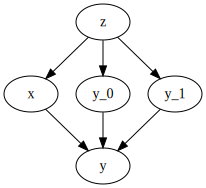

In [4]:
from causalgraphicalmodels.examples import simple_confounded_potential_outcomes

simple_confounded_potential_outcomes.draw()

このとき、

$$
(Y_1, Y_0) \perp X|Z
$$
となることがわかる


## 2. The Causal Calculus

- Goalはcausal graphのjoint probability functionを記述すること

### Notations

<img src = "https://github.com/RyoNakagami/omorikaizuka/blob/master/Econometrics/causal_graph_calculas_notation.jpg?raw=true">



### Pearlの同時確率密度関数のルール

以下のような問題を考える

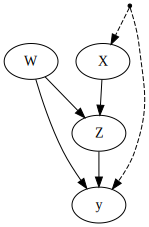

In [5]:
example = CausalGraphicalModel(
    nodes=["X", "Z", "W", "y"],
    edges=[
        ("X", "Z"), 
        ("W", "y"),
        ("W", "Z"), 
        ("Z", "y")
    ],
    latent_edges=[
        ("X", "y")]
)

# draw return a graphviz `dot` object, which jupyter can render
example.draw()


<img src = "https://github.com/RyoNakagami/omorikaizuka/blob/master/Econometrics/pearl_rules.jpg?raw=true">

### Example: Smoking and lung cancer

- Y: lung cancer
- X: smoking
- Z: tar in lungs

$$
p(y|do(x))
$$

をobservational dataから推定したいとする。このとき、causal graphは以下のように表されるとする：

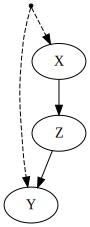

In [6]:
example = CausalGraphicalModel(
    nodes=["X", "Z", "Y"],
    edges=[
        ("X", "Z"), 
        ("Z", "Y")
    ],
    latent_edges=[
        ("X", "Y")]
)

# draw return a graphviz `dot` object, which jupyter can render
example.draw()

### 推定方法

$$
\begin{aligned}
p(y|do(x)) & = \sum_z p(y|z, do(x))p(z|do(x))\\
& = \sum_z p(y|z, do(x))p(z|x) \because \text{ rule 2: } (Z\perp X)_{G_{\underline X}} \\
& = \sum_z p(y|d(z), do(x))p(z|x) \because \text{ rule 2: } (Y\perp Z|X)_{G_{\bar X\underline Z}} \\
& = \sum_z p(y|d(z))p(z|x) \because \text{ rule 3: } (Y\perp X|Z)_{G_{\bar X\bar Z}} \\
\end{aligned}
$$

同様に

$$
\begin{aligned}
p(y|do(z)0 & = \sum_xp(y|x, do(z))p(x|do(z))\\
&= \sum_x p(y|x, z)p(x)
\end{aligned}
$$

Then,

$$
p(y|do(x)) = \sum_{z, x'}p(y|x', z)p(z|x')p(x')
$$



## 3. InterventionをToy exampleで確認

In [7]:
def generate_data_1(n, set_x = None):
    if set_x:
        x = np.ones(n)*set_x
    else:
        x = np.random.randn(n)
    y = x + 1 + np.sqrt(3)*np.random.randn(n)
    return x, y

def generate_data_2(n, set_x = None):
    y = 1 + 2*np.random.randn(n)
    if set_x:
        x = np.ones(n)*set_x
    else:
        x = (y - 1)/4 + np.sqrt(3)*np.random.randn(n)/2
    return x, y

def generate_data_3(n, set_x = None):
    z = np.random.randn(n)
    if set_x:
        x = np.ones(n)*set_x
    else:
        x = z
    y = z + 1 + np.sqrt(3)*np.random.randn(n)
    return x, y

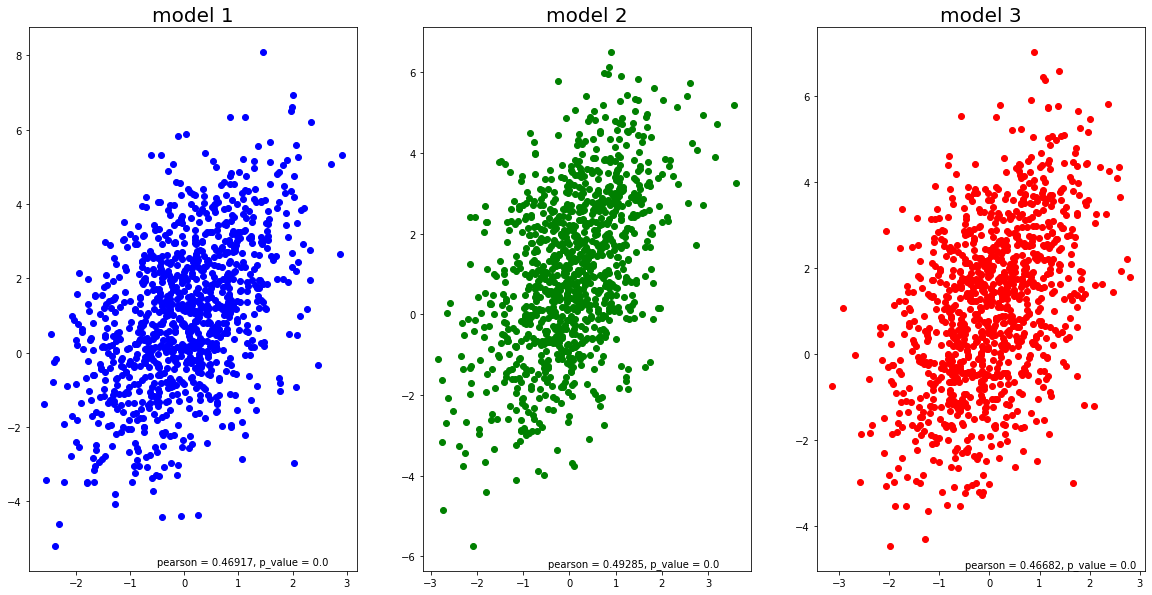

In [8]:
np.random.seed(1010)
n = 1000
colour = ['b', 'g', 'r']

fig, ax = plt.subplots(1,3, figsize = (20, 10))

for i, j in enumerate([generate_data_1, generate_data_2, generate_data_3]):
    x, y = j(n)
    pearson_corr = np.round(stats.pearsonr(x, y), 5)
    ax[i].scatter(x, y, color = colour[i])
    ax[i].set_title('model ' + str(i+1), fontsize = 20)
    ax[i].text(np.mean(x) - 0.5, min(y)-0.5, "pearson = {}, p_value = {}".format(pearson_corr[0], pearson_corr[1] ))


### Intervention

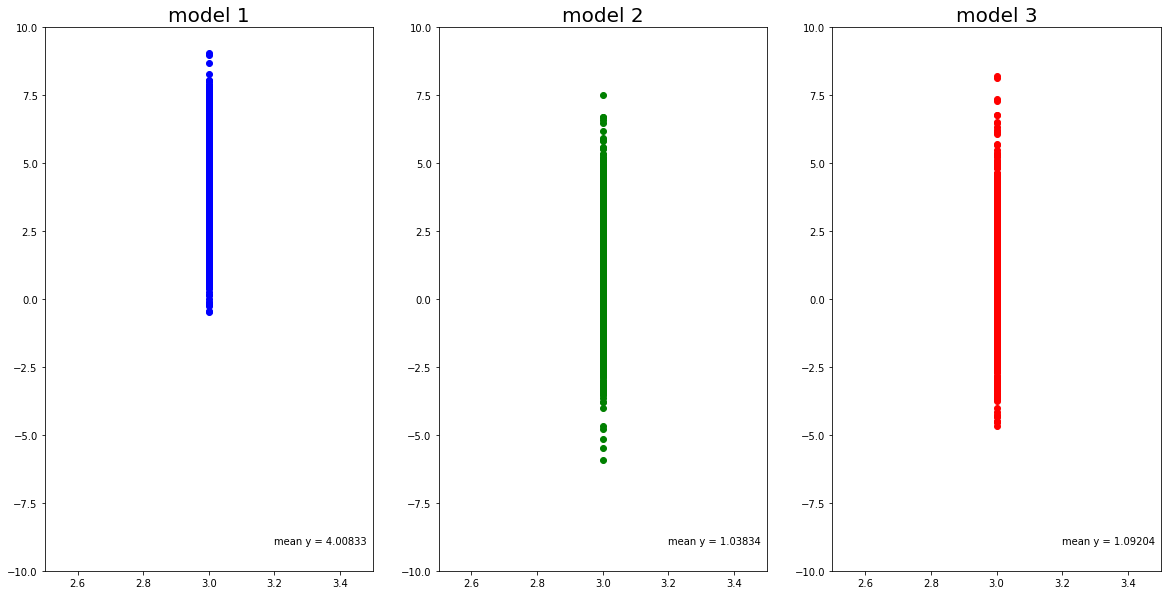

In [9]:
np.random.seed(1010)
n = 1000
colour = ['b', 'g', 'r']

fig, ax = plt.subplots(1,3, figsize = (20, 10))

for i, j in enumerate([generate_data_1, generate_data_2, generate_data_3]):
    x, y = j(n, set_x = 3)
    ax[i].scatter(x, y, color = colour[i])
    ax[i].set_title('model ' + str(i+1), fontsize = 20)
    ax[i].set_xlim(2.5, 3.5)
    ax[i].set_ylim(-10, 10)
    ax[i].text(3.2, -9, "mean y = {}".format(round(np.mean(y), 5)))
    


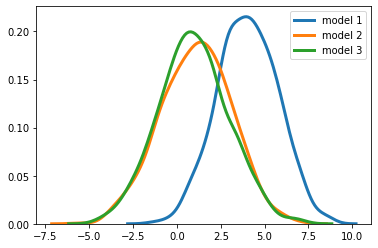

In [10]:
for i, j in enumerate([generate_data_1, generate_data_2, generate_data_3]):
    x, y = j(n, set_x = 3)
    sns.distplot(y, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'model ' + str(i+1))